In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import pickle
import os
from scipy.ndimage import gaussian_filter

plt.rcdefaults()

In [4]:
DATA_PATH = "../data/dataset_pickle"
FILE_EXT = "pickle"


def load_shot(shotno, data_path, file_ext):
    file_path = os.path.join(data_path, f"{shotno}.{file_ext}")
    return pd.read_pickle(file_path)

In [5]:
# get all shot nos
all_shots = [int(os.path.basename(x.split(f".{FILE_EXT}")[0]))
             for x in glob.glob(os.path.join(DATA_PATH, f"*.{FILE_EXT}"))]
if len(all_shots) < 94:  # check if all data is there
    raise ValueError(f"Not all shots found in path /{DATA_PATH}/; found only {len(all_shots)} out of 94")

In [6]:
print(f"List of all shots/pulses:")
print(all_shots)

List of all shots/pulses:
[71292, 72966, 72196, 64820, 64648, 64394, 71226, 70394, 72198, 64658, 71300, 64646, 71259, 70388, 71224, 64662, 71193, 71255, 64670, 64770, 72964, 72919, 70380, 64392, 64774, 73018, 64778, 71189, 64678, 70392, 64666, 73022, 64650, 64834, 72927, 70357, 70355, 72925, 72929, 70359, 71222, 64664, 70390, 64668, 70382, 71265, 73020, 71256, 70387, 64673, 71182, 71190, 64649, 71260, 71303, 64374, 64680, 72967, 64378, 64401, 72920, 72965, 64682, 64376, 72930, 71192, 71225, 70389, 64389, 64647, 64659, 70356, 72926, 72961, 64686, 73023, 71266, 64675, 73019, 70381, 70393, 71188, 71264, 73021, 70391, 71194, 71223, 70383, 64677, 71186, 72959, 72928, 64684, 72963]


In [7]:
shotno = all_shots[3]
#shotno = 71265
data_shot = load_shot(shotno, DATA_PATH, FILE_EXT)

[(1.0361, 1.4546), (1.5156, 1.5574), (1.6085, 1.6194)]


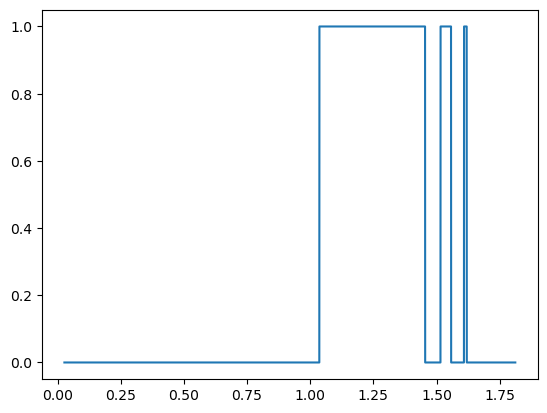

In [13]:
def load_shot_label(shotno, data_path, file_ext):
    file_path = os.path.join(data_path, f"TCV_{shotno}_apau_MHD_labeled.{file_ext}")
    return pd.read_csv(file_path)

LABEL_PATH = "../data/MHD_labels"
FILE_EXT = "csv"
label_shot = load_shot_label(all_shots[0], LABEL_PATH, FILE_EXT)
label_shot

def find_instabilities(df):
    """
    Function to find the start and end times of instabilities in a dataframe.
    
    Parameters:
    df (pd.DataFrame): DataFrame with 'time' and 'MHD_label' columns.

    Returns:
    list: List of tuples with the start and end times of each instability.
    """
    # convert MHD_label value to [0, 1]
    df['MHD_label'] = df['MHD_label'].replace({1: 0, 2: 1})

    # find the transitions
    transitions = df['MHD_label'].ne(df['MHD_label'].shift())

    # extract start and end times of instabilities
    instabilities = []
    start_time = None

    for i in transitions[transitions].index:
        if df.loc[i, 'MHD_label'] == 1:
            # start of instability
            start_time = df.loc[i, 'time']
        elif start_time is not None:
            # end of instability
            end_time = df.loc[i, 'time']
            instabilities.append((start_time, end_time))
            start_time = None  # reset start_time for next instability

    return instabilities

print(find_instabilities(label_shot))
plt.plot(label_shot['time'], label_shot['MHD_label'])

In [7]:
print(f"Example structure of shot #{shotno}:")


def explore_structure(data, indent=0):
    """Recursively prints the structure of nested dictionaries/lists."""
    if isinstance(data, dict):
        for key, value in data.items():
            print('  ' * indent + str(key))
            explore_structure(value, indent + 1)
    elif isinstance(data, list):
        if len(data) > 0:
            print('  ' * indent + f'List of {len(data)} items - showing type of first item')
            explore_structure(data[0], indent + 1)
        else:
            print('  ' * indent + 'Empty List')
    elif isinstance(data, np.ndarray):
        print('  ' * indent + f'NumPy Array - shape: {data.shape}, dtype: {data.dtype}')
    else:
        print('  ' * indent + f'{type(data)}')

#explore_structure(data_shot)
#data_shot['x']['spectrogram']['OddN'].mean()

Example structure of shot #64820:


In [7]:
# Extracting inputs
inputs = data_shot["x"]["spectrogram"]
spec_even = inputs["EvenN"]
spec_odd = inputs["OddN"]
f = inputs["frequency"]
t = inputs["time"]


# Function to plot spectrogram
def plot_spectrogram(spec, title, time, frequency, start_longest_mode=None, end_longest_mode=None):
    fig, ax = plt.subplots()
    ax.imshow(spec.T, extent=(time[0], time[-1], frequency[0], frequency[-1]), aspect='auto', cmap='jet',
              origin='lower')
    ax.set_xlim(time[0], time[-1])
    ax.set_ylim(frequency[0], frequency[-1])
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Frequency [Hz]")
    fig.set_dpi(150)
    plt.title(title)

    # Plot vertical lines if start and end times are provided
    if start_longest_mode is not None and end_longest_mode is not None:
        ax.axvline(x=start_longest_mode, color='blue', linestyle='--', label='Start of Longest Mode')
        ax.axvline(x=end_longest_mode, color='darkblue', linestyle='--', label='End of Longest Mode')
        plt.legend(loc='upper left')

    plt.show()

In [8]:
#plot_spectrogram(spec_odd, "Odd N", t, f)
#plot_spectrogram(spec_even, "Even N", t, f)

0.0008217461563935419


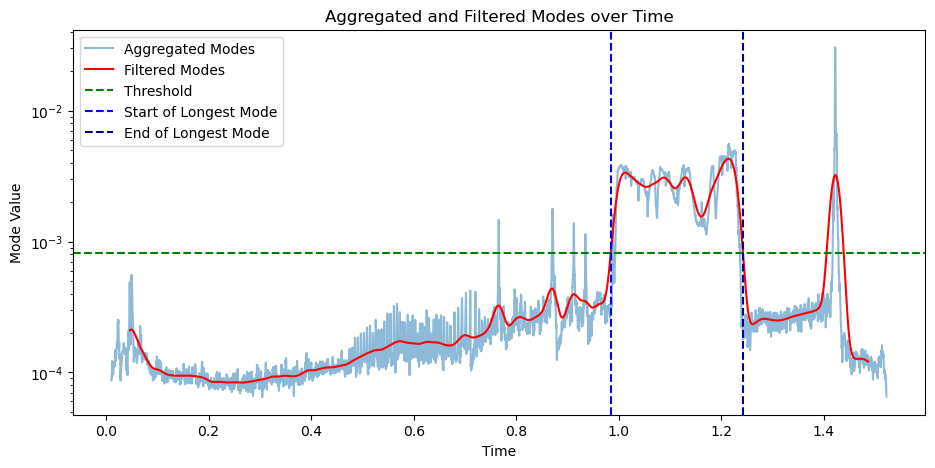

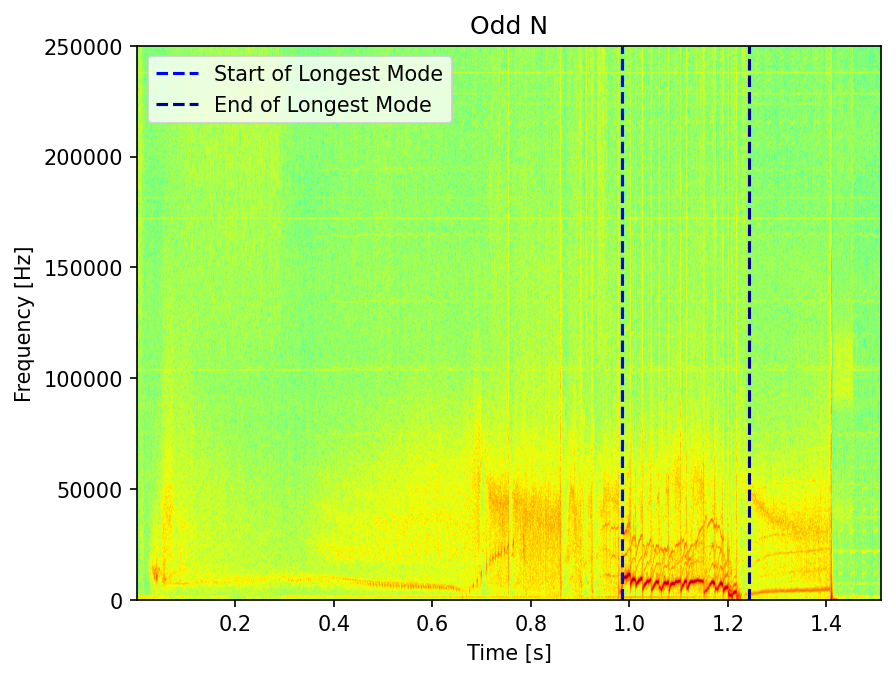

In [9]:
def compute_adaptive_threshold(modes, std_factor, mean_factor):
    if np.all(np.isnan(modes)):
        return np.nan  # Return NaN if all values are NaN
    if np.std(modes) == 0:
        return np.nan  # Return NaN if standard deviation is zero
    mean_val = np.nanmean(modes)  # Use nanmean to ignore NaN values
    std_dev = np.nanstd(modes)  # Use nanstd to ignore NaN values
    
    return mean_factor * mean_val + std_factor * std_dev


def plot_aggregated_modes(label_sources, mode_thresh=0.0005, std_factor=0.25, mean_factor=0.8):
    # Aggregating modes
    modes = np.sum(np.stack([label_sources[f"N{i}"] for i in range(5)]), axis=0) + label_sources["LM"]
    time = label_sources["time"]

    # Applying Gaussian filter
    filtered_modes = gaussian_filter(modes, sigma=45)

    # Calculate adaptive threshold based on the filtered modes
    mode_thresh = compute_adaptive_threshold(filtered_modes, std_factor, mean_factor)
    print(mode_thresh)

    # Find the longest mode segment above the threshold
    above_threshold = filtered_modes > mode_thresh
    change_points = np.diff(above_threshold).nonzero()[0] + 1
    if above_threshold[0]:
        change_points = np.insert(change_points, 0, 0)
    if above_threshold[-1]:
        change_points = np.append(change_points, len(above_threshold))

    segment_lengths = change_points[1::2] - change_points[::2]
    if len(segment_lengths) > 0:
        longest_segment_index = np.argmax(segment_lengths)
        start_longest_mode = time[change_points[2 * longest_segment_index]]
        end_longest_mode = time[change_points[2 * longest_segment_index + 1]]

    # Plotting
    plt.figure(figsize=(11, 5))
    plt.plot(time, modes, label='Aggregated Modes', alpha=0.5)
    plt.plot(time, filtered_modes, label='Filtered Modes', color='red')
    plt.axhline(y=mode_thresh, color='green', linestyle='--', label='Threshold')
    plt.xlabel('Time')
    plt.ylabel('Mode Value')
    plt.title('Aggregated and Filtered Modes over Time')
    plt.yscale('log')

    # Highlight the longest mode segment
    if len(segment_lengths) > 0:
        plt.axvline(x=start_longest_mode, color='blue', linestyle='--', label='Start of Longest Mode')
        plt.axvline(x=end_longest_mode, color='darkblue', linestyle='--', label='End of Longest Mode')

    plt.legend()
    plt.show()

    return (start_longest_mode, end_longest_mode) if len(segment_lengths) > 0 else (None, None)


slm, elm = plot_aggregated_modes(data_shot['y']['modes'])
plot_spectrogram(spec_odd, "Odd N", t, f, slm, elm)

### i

In [ ]:
for shotno in all_shots[:20]:
    data_shot = load_shot(shotno, DATA_PATH, FILE_EXT)
    inputs = data_shot["x"]["spectrogram"]
    spec_odd = inputs["OddN"]
    f = inputs["frequency"]
    t = inputs["time"]

    slm, elm = plot_aggregated_modes(data_shot['y']['modes'], mode_thresh=0.0005)
    plot_spectrogram(spec_odd, f"Odd N\n shot #{shotno}", t, f, slm, elm)

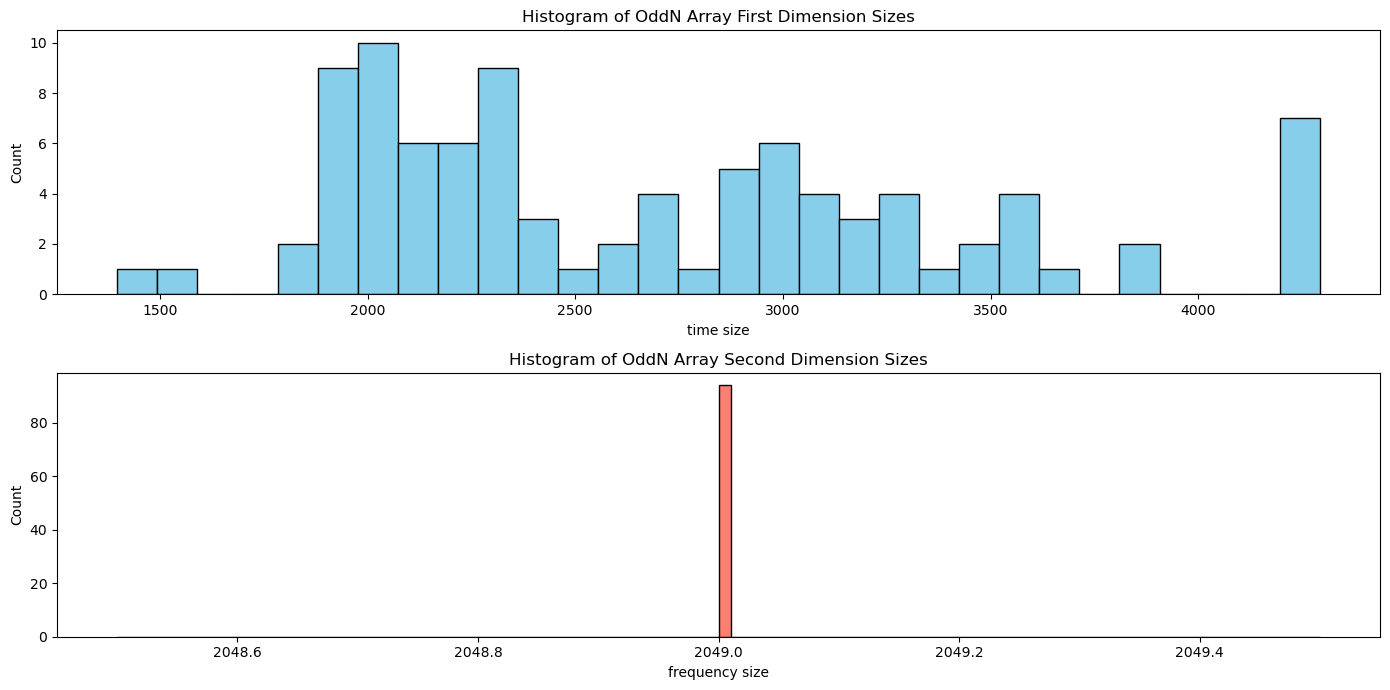

In [11]:
import matplotlib.pyplot as plt

dim1_sizes = []  # List to store the sizes of the first dimension of OddN
dim2_sizes = []  # List to store the sizes of the second dimension of OddN

for shotno in all_shots:
    data_shot = load_shot(shotno, DATA_PATH, FILE_EXT)
    inputs = data_shot["x"]["spectrogram"]
    odd_shape = inputs["OddN"].shape  # Assuming 'OddN' is a 2D array
    dim1_sizes.append(odd_shape[0])  # Size of the first dimension (e.g., frequency)
    dim2_sizes.append(odd_shape[1])  # Size of the second dimension (e.g., time)

# Plotting histograms of the dimensions
plt.figure(figsize=(14, 7))

# Histogram for the first dimension sizes
plt.subplot(2, 1, 1)
plt.hist(dim1_sizes, bins=30, color='skyblue', edgecolor='black')
plt.xlabel('time size')
plt.ylabel('Count')
plt.title('Histogram of OddN Array First Dimension Sizes')

# Histogram for the second dimension sizes
plt.subplot(2, 1, 2)
plt.hist(dim2_sizes, bins=100, color='salmon', edgecolor='black')
plt.xlabel('frequency size')
plt.ylabel('Count')
plt.title('Histogram of OddN Array Second Dimension Sizes')

plt.tight_layout()
plt.show()


In [8]:
data_shot = load_shot(all_shots[10], DATA_PATH, FILE_EXT)
timestamps = data_shot['x']['spectrogram']['time']
timesteps = []
for i in range(len(timestamps)-1):
    timesteps.append(timestamps[i+1]-timestamps[i])
timesteps # 0.512 ms timesteps, 5.12e-4 seconds

[0.0005120000000000001,
 0.0005119999999999999,
 0.0005120000000000003,
 0.0005119999999999999,
 0.0005119999999999999,
 0.0005119999999999999,
 0.0005120000000000003,
 0.0005120000000000003,
 0.0005119999999999994,
 0.0005120000000000003,
 0.0005119999999999994,
 0.0005120000000000003,
 0.0005120000000000003,
 0.0005119999999999994,
 0.0005120000000000003,
 0.0005120000000000003,
 0.0005120000000000003,
 0.0005120000000000003,
 0.0005119999999999986,
 0.0005120000000000003,
 0.0005120000000000003,
 0.0005120000000000003,
 0.0005120000000000003,
 0.0005119999999999986,
 0.0005120000000000003,
 0.0005120000000000003,
 0.0005120000000000003,
 0.0005120000000000003,
 0.0005120000000000003,
 0.0005119999999999986,
 0.000512000000000002,
 0.0005119999999999986,
 0.0005119999999999986,
 0.000512000000000002,
 0.0005119999999999986,
 0.000512000000000002,
 0.0005119999999999986,
 0.000512000000000002,
 0.0005119999999999986,
 0.0005119999999999986,
 0.000512000000000002,
 0.000511999999999998

In [9]:
freq_df = pd.DataFrame(data_shot['x']['spectrogram'][('frequency')])
freq_df # index 800 --> ~97kHz

,0
0,0.000000
1,122.070312
2,244.140625
3,366.210938
4,488.281250
...,...
2044,249511.718750
2045,249633.789062
2046,249755.859375
2047,249877.929688


In [15]:
data_shot = load_shot(all_shots[11], DATA_PATH, FILE_EXT)
print(all_shots[11])
data_shot['x']['spectrogram']['time']

64646


array([0.002048, 0.003072, 0.004096, ..., 1.95584 , 1.956864, 1.957888])

In [42]:
spec_df = pd.DataFrame(data_shot['x']['spectrogram'][('OddN')])
spec_df.head()

,0,1,2,3,4,5,6,7,8,9,...,2039,2040,2041,2042,2043,2044,2045,2046,2047,2048
0,-69.123417,-66.531637,-67.807168,-69.995055,-73.141517,-76.984722,-79.844405,-79.734068,-78.253464,-76.683304,...,-87.848060,-89.543542,-92.039571,-94.405077,-94.026158,-91.639041,-89.517710,-88.094166,-87.295997,-90.050073
1,-68.387383,-65.718651,-66.746777,-68.458418,-70.776181,-73.320934,-75.092641,-75.335040,-74.769590,-74.225988,...,-92.396148,-91.213996,-90.107546,-89.469727,-89.415612,-89.988946,-91.240244,-93.223517,-95.747846,-100.262899
2,-67.608128,-64.905741,-65.853987,-67.527905,-70.122141,-74.092711,-80.658672,-86.470934,-79.994381,-76.724712,...,-100.881568,-98.301815,-95.638131,-93.805851,-93.055815,-93.451143,-95.053507,-98.005055,-102.556673,-109.602179
3,-68.846905,-66.203504,-67.313627,-69.187710,-71.815068,-74.975313,-77.750457,-78.732661,-78.184286,-77.215548,...,-88.077158,-87.370829,-86.234282,-85.275550,-84.714595,-84.566194,-84.758862,-85.156448,-85.553170,-88.731605
4,-70.525253,-67.811197,-68.704128,-70.205124,-72.316665,-74.920062,-77.283374,-77.739476,-76.407899,-74.997384,...,-81.803076,-81.657660,-81.840123,-82.310271,-82.998978,-83.791190,-84.528441,-85.065867,-85.354977,-88.450029


In [ ]:
from torch.utils.data import Dataset

class SpectrogramDataset(Dataset):
    def __init__(self, spectrograms, instabilities, slice_length=20, overlap=0.5, time_step=5.12e-4):
        """
        spectrograms: List of spectrogram tensors
        instabilities: List of tuples (start_time, end_time) for each spectrogram
        slice_length: Number of time steps in each slice
        overlap: Fraction of overlap between consecutive slices (0 to 1)
        time_step: Duration of each time step in ms
        """
        self.spectrograms = spectrograms
        self.instabilities = instabilities
        self.slice_length = slice_length
        self.step = int(slice_length * (1 - overlap))  # Step size for moving the window
        self.time_step = time_step

        # calculate total number of slices across all spectrograms
        self.total_slices = []
        for s in self.spectrograms:
            num_slices = 1 + (s.shape[1] - slice_length) // self.step
            self.total_slices.append(num_slices)

    def __len__(self):
        return sum(self.total_slices)

    def __getitem__(self, idx):
        spectrogram_idx = 0
        # iterate through the spectrograms find which spectrogram idx belongs to
        while idx >= self.total_slices[spectrogram_idx]:
            idx -= self.total_slices[spectrogram_idx]
            spectrogram_idx += 1
        # resulting idx is now the index of the slice in spectrogram spectrogram_idx

        # compute the starting position of the slice
        start = idx * self.step
        end = start + self.slice_length

        # compute the time range of the slice
        start_time = start * self.time_step
        end_time = start_time + self.slice_length * self.time_step

        # slice the spectrogram
        slice = self.spectrograms[spectrogram_idx][:, start:end]

        # determine the label based on instabilities
        label = 0
        for instability_start, instability_end in self.instabilities[spectrogram_idx]:
            if start_time < instability_end and end_time > instability_start:
                label = 1
                break

        return slice, label

# spectrograms is a list of 2D PyTorch tensors
# instabilities is a list of lists of tuples [(start_time, end_time), ...]
dataset = SpectrogramDataset(spectrograms, instabilities, overlap=0.5)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
